# MNIST Digit Classification - CNN

In [1]:
from __future__ import division, print_function
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import theano
import theano.tensor as T

from theano.tensor.signal import pool
from theano.tensor.nnet import conv2d

import os
%matplotlib inline

In [2]:
DATA_DIR = "../../data"
TRAIN_FILE = os.path.join(DATA_DIR, "mnist_train.csv")
TEST_FILE = os.path.join(DATA_DIR, "mnist_test.csv")

MODEL_FILE = os.path.join(DATA_DIR, "theano-mnist-cnn")

LEARNING_RATE = 0.001
REG_LAMBDA = 0.01

INPUT_SIZE = 28
BATCH_SIZE = 128
NUM_CLASSES = 10
NUM_EPOCHS = 5

## Prepare Data

In [3]:
def parse_file(filename):
    xdata, ydata = [], []
    fin = open(filename, "rb")
    i = 0
    for line in fin:
        if i % 10000 == 0:
            print("{:s}: {:d} lines read".format(
                os.path.basename(filename), i))
        cols = line.strip().split(",")
        ydata.append(int(cols[0]))
        x1d = np.array([float(x) / 255. for x in cols[1:]])
#         x1d = np.array([float(x) for x in cols[1:]])
        x3d = np.reshape(x1d, (1, INPUT_SIZE, INPUT_SIZE))
        xdata.append(x3d)
        i += 1
    fin.close()
    print("{:s}: {:d} lines read".format(os.path.basename(filename), i))
    X = np.array(xdata).astype("float32")
    y = np.array(ydata).astype("int32")
    return X, y

Xtrain, ytrain = parse_file(TRAIN_FILE)
Xtest, ytest = parse_file(TEST_FILE)
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

mnist_train.csv: 0 lines read
mnist_train.csv: 10000 lines read
mnist_train.csv: 20000 lines read
mnist_train.csv: 30000 lines read
mnist_train.csv: 40000 lines read
mnist_train.csv: 50000 lines read
mnist_train.csv: 60000 lines read
mnist_test.csv: 0 lines read
mnist_test.csv: 10000 lines read
(60000, 1, 28, 28) (60000,) (10000, 1, 28, 28) (10000,)


## Define Network

In [4]:
X = T.ftensor4("X")
y = T.ivector("y")

In [5]:
# CONV1: 5x5 kernel, channels: 1 => 32
# filtering reduces the image size to (28-5+1 , 28-5+1) = (24, 24)
# maxpooling reduces this further to (24/2, 24/2) = (12, 12)
# output tensor of shape (batch_size, 32, 12, 12)
W1 = theano.shared(np.random.randn(32, 1, 5, 5)
                   .astype(theano.config.floatX), name="W1")
conv_1 = conv2d(input=X, filters=W1, filter_shape=(32, 1, 5, 5),
                input_shape=(BATCH_SIZE, 1, INPUT_SIZE, INPUT_SIZE))
pool_1 = pool.pool_2d(input=conv_1, ws=(2, 2), ignore_border=True)
# relu_1 = T.nnet.relu(pool_1)
relu_1 = T.tanh(pool_1)

# CONV2: 5x5 kernel, channels: 32 => 64
# filtering reduces the image size to (12-5+1, 12-5+1) = (8, 8)
# maxpooling reduces this further to (8/2, 8/2) = (4, 4)
# output tensor of shape (batch_size, 64, 4, 4)
W2 = theano.shared(np.random.randn(64, 32, 5, 5)
                   .astype(theano.config.floatX), name="W2")
conv_2 = conv2d(input=relu_1, filters=W2, filter_shape=(64, 32, 5, 5),
               input_shape=(BATCH_SIZE, 32, 12, 12))
pool_2 = pool.pool_2d(input=conv_2, ws=(2, 2), ignore_border=True)
# relu_2 = T.nnet.relu(pool_2)
relu_2 = T.tanh(pool_2)

# output tensor of shape (batch_size, 1024)
flat_3 = relu_2.reshape((-1, 1024))

# fc1: 1024 => 256
W4 = theano.shared(np.random.randn(1024, 256)
                   .astype(theano.config.floatX), name="W4")
b4 = theano.shared(np.zeros(256).astype(theano.config.floatX), name="b4")
fc4 = flat_3.dot(W4) + b4
# fc4_relu = T.nnet.relu(fc4)
fc4_relu = T.tanh(fc4)

# fc2: 256 => 10
W5 = theano.shared(np.random.randn(256, 10)
                   .astype(theano.config.floatX), name="W5")
b5 = theano.shared(np.zeros(10).astype(theano.config.floatX), name="b5")
fc5 = fc4_relu.dot(W5) + b5
y_hat = T.nnet.softmax(fc5)

In [6]:
loss = T.nnet.categorical_crossentropy(y_hat, y).mean()
prediction = T.argmax(y_hat, axis=1)

In [7]:
forward_prop = theano.function([X], y_hat)
calculate_loss = theano.function([X, y], loss)
predict = theano.function([X], prediction)

In [8]:
params = [W5, b5, W4, b4, W2, W1]
grads = T.grad(loss, params)

In [9]:
updates = [
    (param_i, param_i - LEARNING_RATE * grad_i)
    for param_i, grad_i in zip(params, grads)
]

In [10]:
gradient_step = theano.function(
    [X, y],
    updates=updates
)

## Train Network

In [11]:
history = []
num_batches = len(Xtrain) // BATCH_SIZE
num_val_recs = len(Xtrain) // 10
Xval, yval = Xtrain[0:num_val_recs], ytrain[0:num_val_recs]
for epoch in range(NUM_EPOCHS):
    shuffled_indices = np.random.permutation(np.arange(len(Xtrain)))
    total_loss, total_acc = 0., 0.
    for bid in range(num_batches - 1):
        bstart = bid * BATCH_SIZE
        bend = (bid + 1) * BATCH_SIZE
        Xbatch = np.array([Xtrain[i] for i in shuffled_indices[bstart:bend]])
        ybatch = np.array([ytrain[i] for i in shuffled_indices[bstart:bend]])
        gradient_step(Xbatch, ybatch)
        total_loss += calculate_loss(Xbatch, ybatch)
    total_loss /= num_batches
    # validate with 10% training data
    yval_ = predict(Xval)
    total_acc = accuracy_score(yval_, yval)
    history.append((total_loss, total_acc))
    print("Epoch {:d}/{:d}: loss={:.4f}, accuracy: {:.4f}".format(
        epoch+1, NUM_EPOCHS, total_loss, total_acc))    


Epoch 1/5: loss=15.6522, accuracy: 0.1622
Epoch 2/5: loss=11.2962, accuracy: 0.2275
Epoch 3/5: loss=9.0104, accuracy: 0.2973
Epoch 4/5: loss=7.4783, accuracy: 0.3568
Epoch 5/5: loss=6.4523, accuracy: 0.4033


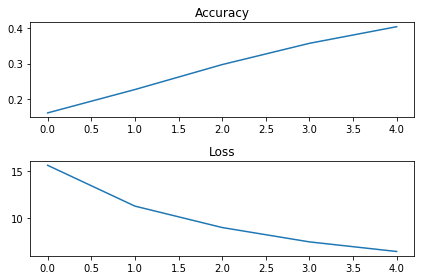

In [12]:
losses = [x[0] for x in history]
accs = [x[1] for x in history]

plt.subplot(211)
plt.title("Accuracy")
plt.plot(accs)

plt.subplot(212)
plt.title("Loss")
plt.plot(losses)

plt.tight_layout()
plt.show()

## Evaluate Network

In [13]:
predict_fn = theano.function([X], prediction)
ytest_ = predict_fn(Xtest)
acc = accuracy_score(ytest_, ytest)
cm = confusion_matrix(ytest_, ytest)
print("accuracy: {:.3f}".format(acc))
print("confusion matrix")
print(cm)

accuracy: 0.399
confusion matrix
[[467   4  60 105  55  76 120  53  78  38]
 [  1 826  44  13  14  18  14  28  18  14]
 [ 67  81 378 129  73  79  61 119  61  51]
 [ 40  44 109 395  32 175  20 114  96  80]
 [ 38  29  37  60 261  84  51  89 113 192]
 [101  20 110  83  98 149 103  30  74  53]
 [ 88  39  62  30  72  98 418  55  65  72]
 [100  12  69  51  68  79  41 403  51 121]
 [ 52  63 130 107  82  68  78  38 363  58]
 [ 26  17  33  37 227  66  52  99  55 330]]
